In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../../")
sys.path.append("../../../covid19_inference")
sys.path.append("../../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
def load_function(country, offset=0, mwd="1.0", interval_cps="10.0", f_fem="0.33", f_robust="1.0", len="normal"):
        folder="covid_uefa_traces14_robustness"
        fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/{folder}/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data={offset}"+
            f"-prior_delay=-1"+
            f"-median_width_delay={mwd}"+
            f"-interval_cps={interval_cps}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if not f_robust == "1.0":
            fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
                f"-beta=False"+
                f"-country={country}"+
                f"-offset_data={offset}"+
                f"-prior_delay=-1"+
                f"-median_width_delay={mwd}"+
                f"-interval_cps={interval_cps}"+
                f"-f_fem={f_fem}"+
                f"-len=normal"+
                f"-abs_sine=False"+
                f"-t={tune}"+
                f"-d={draws}"+
                f"-max_treedepth={max_treedepth}.pkl")
        model = None
        
        tune, draws, max_treedepth = (2000, 4000, 12)
        folder="covid_uefa_traces14_robustness"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
            
        tune, draws, max_treedepth = (1000, 2000, 12)
        folder="covid_uefa_traces15"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)) and model is None:
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        
        if model is None: 
            print(fstr(tune, draws, max_treedepth, folder), " not found")
            return None, None
        
        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)
        return model, trace

In [3]:
# Load data
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']
traces, models, dls = [], [], []
offsets = [-14]
traces, traces_without_soccer, traces_primary_soccer, models, dls = {}, {}, {}, {}, {}

for country in tqdm(countries):
    models_temp = []
    traces_temp = []
    traces_without_soccer_temp = []
    traces_primary_soccer_temp = []
    dls_temp = []
    for offset in offsets:
        print(f"{country} {offset}" )

        model,trace = load_function(country, offset= offset)
    
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_data=offset)
        models_temp.append(model)
        traces_temp.append(trace)
        
        
        dls_temp.append(dl)
    models[country] = models_temp
    
    traces[country] = traces_temp
    traces_without_soccer[country] = traces_without_soccer_temp
    traces_primary_soccer[country] = traces_primary_soccer_temp
    
    dls[country] = dls_temp



  0%|          | 0/12 [00:00<?, ?it/s]

England -14
Use 4000 sample runs for England with -14 offset
Czechia -14
Use 4000 sample runs for Czechia with -14 offset
Scotland -14
Use 4000 sample runs for Scotland with -14 offset
Spain -14
Use 4000 sample runs for Spain with -14 offset
Italy -14
Use 4000 sample runs for Italy with -14 offset
Slovakia -14
Use 2000 sample runs for Slovakia with -14 offset
Germany -14
Use 4000 sample runs for Germany with -14 offset
Austria -14
Use 2000 sample runs for Austria with -14 offset
Belgium -14
Use 2000 sample runs for Belgium with -14 offset
France -14
Use 4000 sample runs for France with -14 offset
Portugal -14
Use 2000 sample runs for Portugal with -14 offset
Netherlands -14
Use 2000 sample runs for Netherlands with -14 offset


In [4]:
# Compute interesting values as fraction
primary_frac = []
for i, country in enumerate(countries):
    primary_frac_t = []
    
    for o, offset in enumerate(offsets):
        if models[country][o] is None:
            print(f"Country {country} with offset {offset} not found")
            o = 3
        traces[country][o].posterior = traces[country][o].posterior.isel(draw=np.arange(-2000,0), chain=np.arange(6)) # make all the same shape
        frac_pr = covid19_soccer.plot.other.calc_fraction_primary(model=models[country][o], trace=traces[country][o], dl=dls[country][o])
        primary_frac_t.append(frac_pr*100)
    primary_frac.append(np.array(primary_frac_t)[0]) # Index 0 because of only one offset

In [5]:
def whisker_plot_v(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.axhline(0, color="tab:gray", ls="--", zorder=-10)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(axis="y",bottom=False)

In [6]:
traces_array = []
models_array = []
dls_array = []
for t in traces:
    traces_array.append(traces[t][0])
    models_array.append(models[t][0])
    dls_array.append(dls[t][0])

/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/robustness/../../../covid19_soccer/plot/other.py:1259: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/smohr/Repositories/covid19_soccer/notebooks/supplementary/robustness/../../../covid19_soccer/plot/other.py:1263: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)
<ipython-input-8-f5fd0ce4dd6f>:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


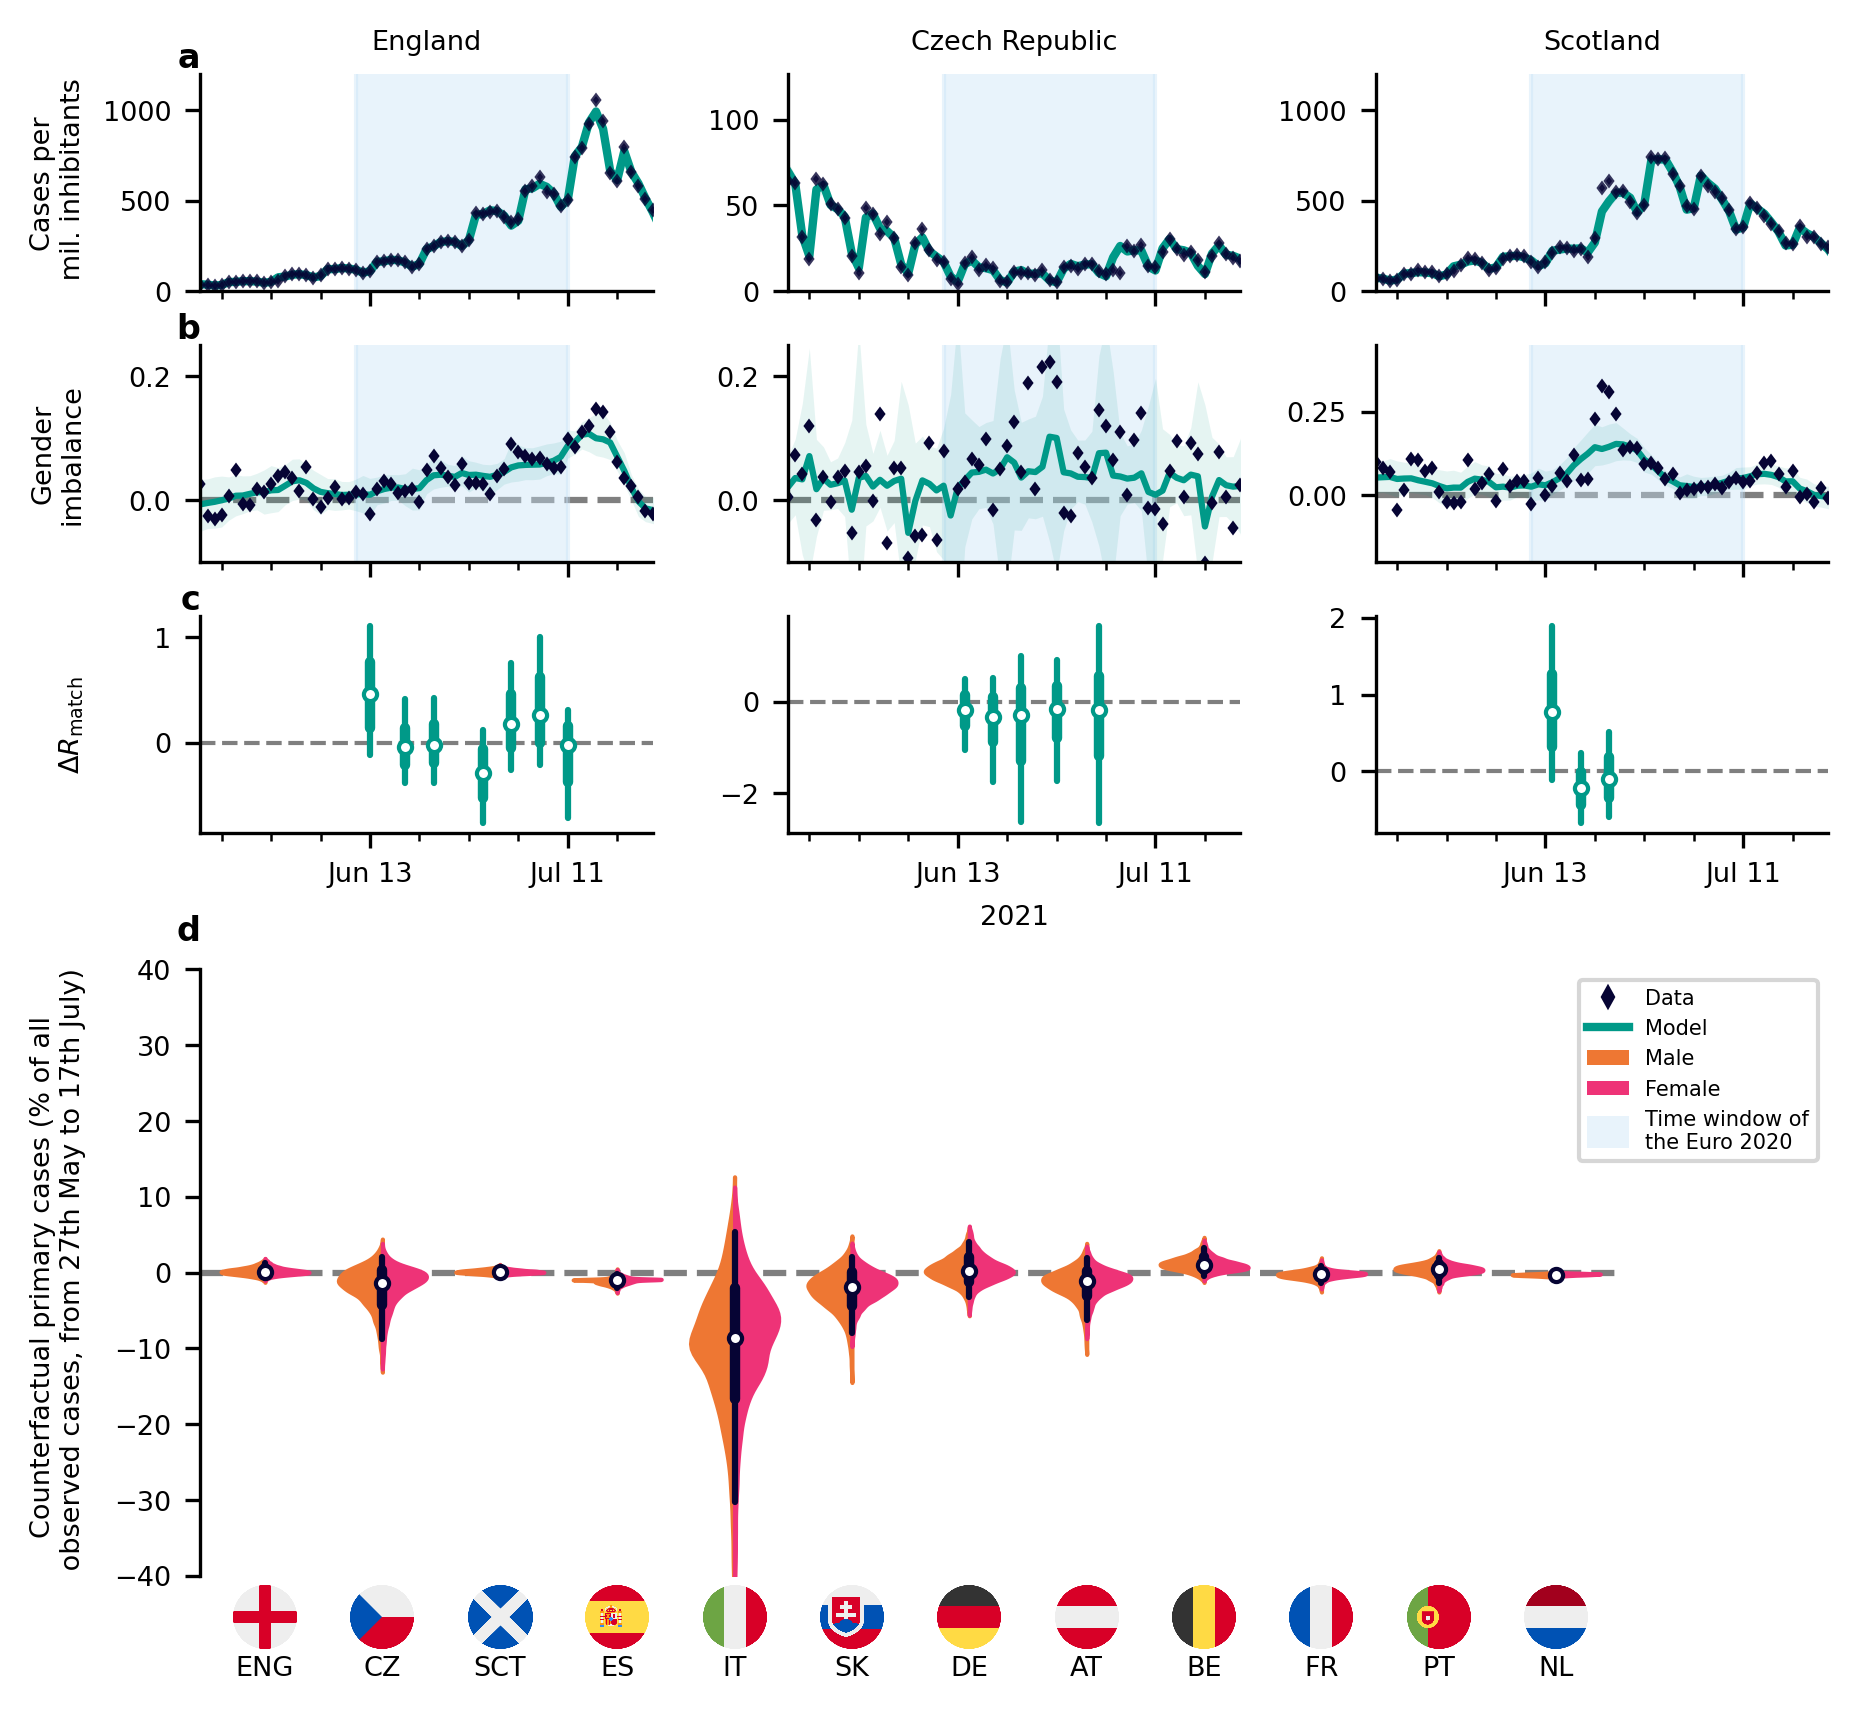

In [8]:
from covid19_soccer.plot.other import hviolins, legend, plot_flags
import string

xlim_ts = [datetime.datetime(2021,5,20),datetime.datetime(2021,7,23)] # Plotting range
country_order = range(7)
selected_index = [0,1,2]

# Create figure
plt.close("all")
fig = plt.figure(figsize=(7, 6.5))
axes, outer_outer_grid = covid19_soccer.plot.overview.multi_v2(
    traces=traces_array,
    models=models_array,
    dls=dls_array,
    xlim=xlim_ts,
    selected_index=[0,1,2],
    nColumns=3,
    fig=fig,
    ypos_flags=-40,
    country_order=country_order,
    shift_model=-14,
    shift_data=-14
)

# Add label letters to figure
letters = list(string.ascii_lowercase)
text_kwargs = {
    "fontsize":8,
    "fontweight":"bold",
    "verticalalignment":"top",
    "ha":"right"
}
axes[0][0].text(
    s=letters[0],
    transform=axes[0][0].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)
axes[0][1].text(
    s=letters[1],
    transform=axes[0][1].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)
axes[0][2].text(
    s=letters[2],
    transform=axes[0][2].transAxes,
    x=0,
    y=1.15,
    **text_kwargs
)


axes[0][0].set_ylim(0,1200)

axes[2][0].set_ylim(0,1200)

axes[0][0].set_ylabel("Cases per\n mil. inhibitants")
axes[1][2].set_xlabel("2021")
axes[0][2].set_ylabel("$\Delta R_{\mathrm{match}}$")



axes[0][1].set_ylim(-0.1,0.25)
axes[2][1].set_ylim(-0.2,0.45)
axes[1][1].set_ylim(-0.1,0.25)


inner_grid = outer_outer_grid[-1].subgridspec(1, 2, width_ratios=(12.0, 0.5))

# Plot percentage of soccer
ax = fig.add_subplot(inner_grid[0, 0])

hviolins(
    ax,
    [frac.T for frac in primary_frac],
    countries
)
ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac]
ci = np.array(ci).T
whisker_plot_v(
    ax,
    countries,
    ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:]
)
ax.set_ylabel("Counterfactual primary cases (% of all \n observed cases, from 27th May to 17th July)")
ax.set_ylim(-40,40)
#ax.set_xlim(-0.5,6.5)
ax.text(
    s=letters[3],
    transform=ax.transAxes,
    x=0,
    y=1.09,
    **text_kwargs
)
ax.get_legend().remove()

labels = [dl.countries_iso2[0].replace("GB-","") for dl in dls_array]
plot_flags(
    ax,
    labels,
    -40
)
ax.set_xticklabels(labels)
ax.set_xlabel(None)
import matplotlib.transforms as mtrans
trans = mtrans.Affine2D().translate(0, -50)
labels = ax.get_xticklabels()
for label in labels:
    label.set_transform(label.get_transform()+trans)
ax.xaxis.set_ticks_position('none') 
ax = fig.add_subplot(inner_grid[0, 1])
legend(ax=ax, posterior=False, prior=False, championship_range=True)


plt.tight_layout()
fig.align_ylabels()

# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}
plt.show()
fig.savefig(f"../../../figures/SI/robustness/offset_-14.pdf", **save_kwargs)
fig.savefig(f"../../../figures/SI/robustness/offset_-14.png", **save_kwargs)
plt.close(fig=fig)

In [9]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Oct 18 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]
matplotlib       : 3.5.1
pandas           : 1.2.4
covid19_inference: 0.3.6
numpy            : 1.20.3

Watermark: 2.3.1

